### Machine Learning with Big Data
## Part 2: Convolutional Neural Networks

# 0.3 - Baseline CNN

**Group:** MLBD_Deventer 4   
**Students:** Mathijs Pattipeilohy (512391), Emin Fikret (511275)

In [3]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt

from joblib import load

2025-10-25 12:40:35.729970: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-25 12:40:35.763805: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-25 12:40:35.938915: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-25 12:40:37.075352: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
SEED = 42
EPOCHS = 10
BATCH = 32

tf.keras.utils.set_random_seed(SEED)

In [5]:
ARTIFACTS_DIR = "../artifacts"
MODEL_NAME = "cnn_baseline"

INPUT_FILE = os.path.join(ARTIFACTS_DIR, "images_tuple.joblib")

LOG_DIR   = os.path.join(ARTIFACTS_DIR, "logs", f"{MODEL_NAME}")
MODEL_FILE = os.path.join(ARTIFACTS_DIR, f"{MODEL_NAME}.keras")
CKPT_FILE  = os.path.join(ARTIFACTS_DIR, f"best_{MODEL_NAME}.keras")

In [6]:
(
    X_train, X_val, X_test,
    y_train, y_val, y_test,
    classes
) = load(INPUT_FILE)

num_classes = len(classes)
print("Classes:", classes)
print("Train shape:", X_train.shape, y_train.shape)

Classes: ['az', 'dobro', 'estb', 'frbtb', 'ize', 'jatb', 'ljudie', 'nasb', 'sa', 'sta', 'ukb', 'vede']
Train shape: (900, 128, 128, 4) (900, 12)


## Model V1: Base
This is our baseline CNN for the Glagolitic symbol dataset. We start with a relatively simple model that uses an input layer, an augmentation layer, two convolutional layers, and a softmax output layer. The purpose is to build a working CNN without extra regularization, such as pooling or dropout in order to compare it with later improvements.

In [18]:
MODEL_NAME_V1 = "cnn_baseline_v1"
MODEL_FILE_V1 = os.path.join(ARTIFACTS_DIR, f"{MODEL_NAME_V1}.keras")

model_v1 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=X_train.shape[1:]),
    tf.keras.layers.Rescaling(1.0 / 255), # min-max scale rbg values

    tf.keras.layers.Conv2D(
        16, (3,3), 
        activation="relu",
        # padding is valid, no padding
    ), # learns low-level features, like edges
    tf.keras.layers.Conv2D(
        32, (3,3), 
        activation="relu",
        # padding is valid, no padding
    ), # learns higher-lever combinations, like shapes

    tf.keras.layers.Flatten(), # turns 2d features into 1d vector
    tf.keras.layers.Dense(num_classes, activation="softmax")
])

model_v1.compile(
    optimizer=tf.keras.optimizers.Adam(), # variation of gradient descent
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy()],
)

model_v1.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)         │ (None, 128, 128, 4)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 126, 126, 16)   │           592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 124, 124, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 492032)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 12)             │     5,904,396 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,909,628 (22.54 MB)

 Trainable params: 5,909,628 (22.54 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
callbacks_v1 = [
    tf.keras.callbacks.TensorBoard(log_dir=LOG_DIR),
    # Not included, because we cannot easily compare different models
    # if val_loss does not get better after 3 epochs, 
    # stop training and get the best model weights
    # tf.keras.callbacks.EarlyStopping(
    #     monitor="val_loss", patience=3, restore_best_weights=True
    # ),
    # save best model
    tf.keras.callbacks.ModelCheckpoint(
        CKPT_FILE, monitor="val_categorical_accuracy", save_best_only=True
    )
]

history_v1 = model_v1.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH,
    shuffle=True,
    validation_data=(X_val, y_val),
    # or we could have used "validation_set" param
    callbacks=callbacks_v1,
    verbose=2,
)

Epoch 1/10
29/29 - 10s - 346ms/step - categorical_accuracy: 0.3656 - loss: 18.8889 - val_categorical_accuracy: 0.8062 - val_loss: 0.5343
Epoch 2/10
29/29 - 10s - 339ms/step - categorical_accuracy: 0.8844 - loss: 0.3125 - val_categorical_accuracy: 0.8760 - val_loss: 0.3432
Epoch 3/10
29/29 - 9s - 313ms/step - categorical_accuracy: 0.9700 - loss: 0.1008 - val_categorical_accuracy: 0.9186 - val_loss: 0.2658
Epoch 4/10
29/29 - 8s - 290ms/step - categorical_accuracy: 0.9944 - loss: 0.0281 - val_categorical_accuracy: 0.9070 - val_loss: 0.2766
Epoch 5/10
29/29 - 9s - 298ms/step - categorical_accuracy: 0.9978 - loss: 0.0114 - val_categorical_accuracy: 0.8992 - val_loss: 0.2767
Epoch 6/10
29/29 - 9s - 306ms/step - categorical_accuracy: 0.9978 - loss: 0.0101 - val_categorical_accuracy: 0.8992 - val_loss: 0.2846
Epoch 7/10
29/29 - 9s - 308ms/step - categorical_accuracy: 0.9978 - loss: 0.0098 - val_categorical_accuracy: 0.8992 - val_loss: 0.2888
Epoch 8/10
29/29 - 8s - 271ms/step - categorical_acc

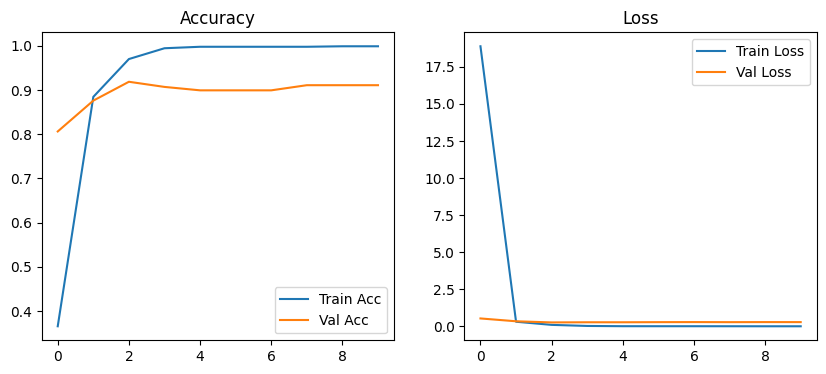

In [20]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(history_v1.history['categorical_accuracy'], label='Train Acc')
plt.plot(history_v1.history['val_categorical_accuracy'], label='Val Acc')
plt.title('Accuracy'); plt.legend()

plt.subplot(1,2,2)
plt.plot(history_v1.history['loss'], label='Train Loss')
plt.plot(history_v1.history['val_loss'], label='Val Loss')
plt.title('Loss'); plt.legend()

plt.show()

In [31]:
test_loss, test_acc = model_v1.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - categorical_accuracy: 0.8698 - loss: 0.6015
Test accuracy: 0.8672


### Results V1: Base

The model performed well but was relatively slow, and some overfitting was visible.

The training accuracy remained very high (close to 1.0), while the validation accuracy decreased slightly after the second epoch. This suggests that the model started to overfit, as it continued improving on the training data while the validation performance fluctuated.

The validation loss stayed close to the training loss, which indicates that the model still generalizes reasonably well and performs consistently on unseen data.

In [32]:
model_v1.save(MODEL_FILE_V1)
print(f"Saved model to {MODEL_FILE_V1}")

Saved model to ../artifacts/cnn_baseline_v1.keras


-----

## Model V2: Filters
In version 2, we only increased the number of filters in both convolutional layers (from 16 to 32, and 32 to 64) to let the model learn more complex and detailed features.

> **Note:** Increasing filters increases capacity and can improve accuracy. However, it also slows down the model because it produces more parameters and makes the model heavier. By increasing the filters in V2, we doubled the number of parameters and the size of the V1 model.

In [33]:
MODEL_NAME_v2 = "cnn_baseline_v2"
MODEL_FILE_V2 = os.path.join(ARTIFACTS_DIR, f"{MODEL_NAME_v2}.keras")

model_v2 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=X_train.shape[1:]),
    tf.keras.layers.Rescaling(1.0 / 255), # min-max scale rbg values

    tf.keras.layers.Conv2D(
        32, (3,3), 
        activation="relu",
    ), # learns low-level features, like edges
    tf.keras.layers.Conv2D(
        64, (3,3), 
        activation="relu",
    ), # learns higher-lever combinations, like shapes

    tf.keras.layers.Flatten(), # turns 2d features into 1d vector
    tf.keras.layers.Dense(num_classes, activation="softmax")
])

model_v2.compile(
    optimizer=tf.keras.optimizers.Adam(), # variation of gradient descent
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy()],
)

model_v2.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_5 (Rescaling)         │ (None, 128, 128, 4)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 126, 126, 32)   │         1,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 124, 124, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 984064)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 12)             │    11,808,780 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,828,460 (45.12 MB)

 Trainable params: 11,828,460 (45.12 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:
callbacks_v2 = [
    tf.keras.callbacks.TensorBoard(log_dir=LOG_DIR),
    # Not included, because we cannot easily compare different models
    # if val_loss does not get better after 3 epochs, 
    # stop training and get the best model weights
    # tf.keras.callbacks.EarlyStopping(
    #     monitor="val_loss", patience=3, restore_best_weights=True
    # ),
    # save best model
    tf.keras.callbacks.ModelCheckpoint(
        CKPT_FILE, monitor="val_categorical_accuracy", save_best_only=True
    )
]

history_v2 = model_v2.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH,
    shuffle=True,
    validation_data=(X_val, y_val),
    # or we could have used "validation_set" param
    callbacks=callbacks_v2,
    verbose=2,
)

Epoch 1/10
29/29 - 16s - 557ms/step - categorical_accuracy: 0.5289 - loss: 11.4186 - val_categorical_accuracy: 0.8101 - val_loss: 0.8536
Epoch 2/10
29/29 - 15s - 518ms/step - categorical_accuracy: 0.8989 - loss: 0.2977 - val_categorical_accuracy: 0.8256 - val_loss: 0.6182
Epoch 3/10
29/29 - 16s - 552ms/step - categorical_accuracy: 0.9700 - loss: 0.0802 - val_categorical_accuracy: 0.8876 - val_loss: 0.3855
Epoch 4/10
29/29 - 16s - 566ms/step - categorical_accuracy: 0.9878 - loss: 0.0346 - val_categorical_accuracy: 0.9031 - val_loss: 0.3256
Epoch 5/10
29/29 - 17s - 582ms/step - categorical_accuracy: 0.9933 - loss: 0.0227 - val_categorical_accuracy: 0.9109 - val_loss: 0.2978
Epoch 6/10
29/29 - 15s - 529ms/step - categorical_accuracy: 0.9967 - loss: 0.0096 - val_categorical_accuracy: 0.9031 - val_loss: 0.3102
Epoch 7/10
29/29 - 15s - 527ms/step - categorical_accuracy: 0.9989 - loss: 0.0068 - val_categorical_accuracy: 0.9109 - val_loss: 0.3044
Epoch 8/10
29/29 - 18s - 611ms/step - categoric

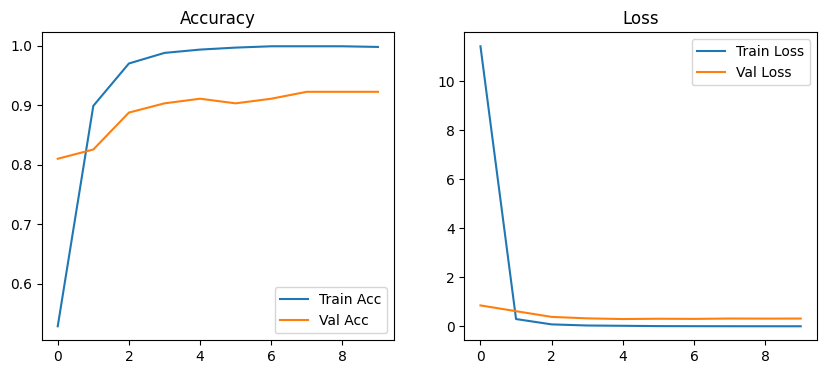

In [35]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(history_v2.history['categorical_accuracy'], label='Train Acc')
plt.plot(history_v2.history['val_categorical_accuracy'], label='Val Acc')
plt.title('Accuracy'); plt.legend()

plt.subplot(1,2,2)
plt.plot(history_v2.history['loss'], label='Train Loss')
plt.plot(history_v2.history['val_loss'], label='Val Loss')
plt.title('Loss'); plt.legend()

plt.show()

In [36]:
test_loss, test_acc = model_v2.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 171ms/step - categorical_accuracy: 0.8979 - loss: 0.5725
Test accuracy: 0.9062


### Results V2: Filters

We increased the number of filters for version 2, which improved the model’s accuracy by 0.4 percent. However, it also doubled the number of parameters and the size of the model, making it heavier than V1.

- This time, the validation accuracy started lower but steadily increased, with a small bump around epoch 5. A similar gap of about 0.1 remained between the training and validation accuracy, showing that mild overfitting was still present.

- The validation loss was as steady as in V1. However, the gap between the training and validation loss slightly increased.

Overall, in terms of accuracy, this model performs better. In terms of speed and size, V1 is still more efficient.

In [37]:
model_v2.save(MODEL_FILE_V2)
print(f"Saved model to {MODEL_FILE_V2}")

Saved model to ../artifacts/cnn_baseline_v2.keras


-----

## Model V3: Padding

In this version, we kept the same number of filters as in V2 but added `padding="same"` to both convolutional layers.

The previous versions used `padding="valid"`, which cuts off border pixels and shrinks the output.

Unlike "valid", "same" adds zeros around the image edges to preserve the original size. 

This helps the model retain important edge details and can improve accuracy, but it also slightly increases model size and training time

In [9]:
MODEL_NAME_V3 = "cnn_baseline_v3"
MODEL_FILE_V3 = os.path.join(ARTIFACTS_DIR, f"{MODEL_NAME_V3}.keras")

model_v3 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=X_train.shape[1:]),
    tf.keras.layers.Rescaling(1.0 / 255), # min-max scale rbg values

    tf.keras.layers.Conv2D(
        32, (3,3), 
        activation="relu",
        padding="same", # add zeros around the edges
    ), # learns low-level features, like edges
    tf.keras.layers.Conv2D(
        64, (3,3), 
        activation="relu",
        padding="same", # add zeros around the edges
    ), # learns higher-lever combinations, like shapes

    tf.keras.layers.Flatten(), # turns 2d features into 1d vector
    tf.keras.layers.Dense(num_classes, activation="softmax")
])

model_v3.compile(
    optimizer=tf.keras.optimizers.Adam(), # variation of gradient descent
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy()],
)

model_v3.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 128, 128, 4)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 32)   │         1,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1048576)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │    12,582,924 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,602,604 (48.08 MB)

 Trainable params: 12,602,604 (48.08 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
callbacks_v3 = [
    tf.keras.callbacks.TensorBoard(log_dir=LOG_DIR),
    # Not included, because we cannot easily compare different models
    # if val_loss does not get better after 3 epochs, 
    # stop training and get the best model weights
    # tf.keras.callbacks.EarlyStopping(
    #     monitor="val_loss", patience=3, restore_best_weights=True
    # ),
    # save best model
    tf.keras.callbacks.ModelCheckpoint(
        CKPT_FILE, monitor="val_categorical_accuracy", save_best_only=True
    )
]

history_v3 = model_v3.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH,
    shuffle=True,
    validation_data=(X_val, y_val),
    # or we could have used "validation_set" param
    callbacks=callbacks_v3,
    verbose=2,
)

Epoch 1/10
29/29 - 19s - 641ms/step - categorical_accuracy: 0.4500 - loss: 28.3480 - val_categorical_accuracy: 0.7752 - val_loss: 0.7076
Epoch 2/10
29/29 - 17s - 601ms/step - categorical_accuracy: 0.8867 - loss: 0.3439 - val_categorical_accuracy: 0.9031 - val_loss: 0.3795
Epoch 3/10
29/29 - 16s - 561ms/step - categorical_accuracy: 0.9822 - loss: 0.0765 - val_categorical_accuracy: 0.8915 - val_loss: 0.4066
Epoch 4/10
29/29 - 17s - 588ms/step - categorical_accuracy: 0.9967 - loss: 0.0207 - val_categorical_accuracy: 0.9031 - val_loss: 0.3693
Epoch 5/10
29/29 - 17s - 602ms/step - categorical_accuracy: 0.9978 - loss: 0.0104 - val_categorical_accuracy: 0.9109 - val_loss: 0.3660
Epoch 6/10
29/29 - 18s - 608ms/step - categorical_accuracy: 0.9978 - loss: 0.0077 - val_categorical_accuracy: 0.8876 - val_loss: 0.3926
Epoch 7/10
29/29 - 16s - 566ms/step - categorical_accuracy: 0.9978 - loss: 0.0055 - val_categorical_accuracy: 0.9264 - val_loss: 0.3919
Epoch 8/10
29/29 - 16s - 566ms/step - categoric

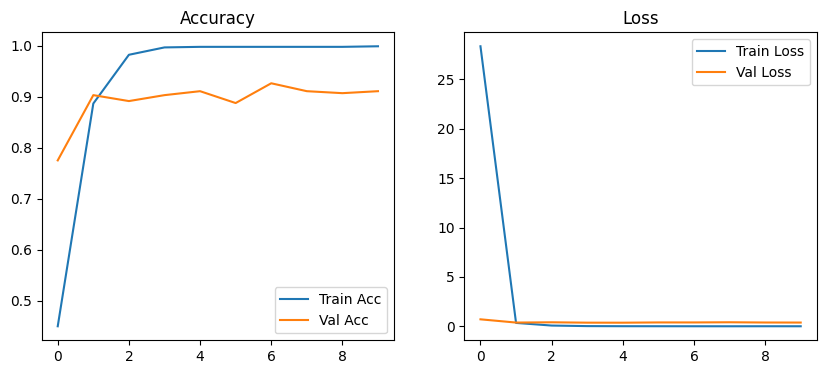

In [12]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(history_v3.history['categorical_accuracy'], label='Train Acc')
plt.plot(history_v3.history['val_categorical_accuracy'], label='Val Acc')
plt.title('Accuracy'); plt.legend()

plt.subplot(1,2,2)
plt.plot(history_v3.history['loss'], label='Train Loss')
plt.plot(history_v3.history['val_loss'], label='Val Loss')
plt.title('Loss'); plt.legend()

plt.show()

In [13]:
test_loss, test_acc = model_v3.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step - categorical_accuracy: 0.8635 - loss: 0.6760
Test accuracy: 0.8516


In [50]:
model_v3.save(MODEL_FILE_V3)
print(f"Saved model to {MODEL_FILE_V3}")

Saved model to ../artifacts/cnn_baseline_v1.keras


### Results V3: Padding

- Compared to V2, the validation accuracy dropped by about 0.5 percent and fluctuated more during training. The gap between training and validation accuracy stayed about the same, showing that overfitting was still present.

- The training and validation loss lines moved closer together, similar to V1, which suggests that the model became slightly more confident and stable in its predictions.

Overall, adding padding helped preserve border information and maintain consistent performance, but it did not improve accuracy and made the model a bit heavier.

In the next version, we will add pooling and dropout layers to reduce overfitting, decrease model size, and narrow the gap between training and validation accuracy.

-----

### References:
- https://www.youtube.com/watch?v=Z0KVRdE_a7Q&list=PLZbbT5o_s2xq7LwI2y8_QtvuXZedL6tQU&index=11
- https://www.geeksforgeeks.org/deep-learning/adam-optimizer/
- https://www.geeksforgeeks.org/deep-learning/training-and-validation-loss-in-deep-learning/